### Setup

In [1]:
import sys
sys.path.append('../')
from src.hp_tuning_functions import *
from src.realtime_utils import *
from plotnine import *

from darts.utils.missing_values import missing_values_ratio, fill_missing_values
from statsmodels.tsa.stattools import acf, pacf

In [2]:
# from darts.utils.statistics import plot_acf, plot_ccf, plot_pacf

In [6]:
def custom_theme():
    return theme(
        plot_title=element_text(size=11),
        strip_text=element_text(size=10),
        legend_title=element_text(size=9),           
        legend_text=element_text(size=8),
        axis_title=element_text(size=10),
        axis_text_x=element_text(size=8, rotation=90, ha='center', ma='right'),
        axis_text_y=element_text(size=8)
    )

In [7]:
def plot_acf(ts, nlags=75, bartlett=True):

    ac_ts, ci = acf(ts, nlags=nlags, alpha=0.05, bartlett_confint=bartlett)

    df_acf = pd.DataFrame({'lag': range(len(ac_ts)), 
                           'ac': ac_ts,
                           'lower' : ci[:, 0],
                           'upper' : ci[:, 1]})

    df_acf.lower -= df_acf.ac
    df_acf.upper -= df_acf.ac

    p = (ggplot(df_acf, aes(x='lag', y='ac'))
     + geom_ribbon(aes(ymin='lower', ymax='upper'), color='skyblue', fill='skyblue', alpha=0.4)
     + theme_bw()
     + geom_point(size=0.6)
     + geom_segment(aes(x='lag', xend='lag', y=0, yend='ac'))
     + labs(x='Lag', y='Autocorrelation')
    )

    return p

In [8]:
def plot_pacf(ts, nlags=75):

    ac_ts, ci = pacf(ts, nlags=nlags, alpha=0.05)

    df_acf = pd.DataFrame({'lag': range(len(ac_ts)), 
                           'ac': ac_ts,
                           'lower' : ci[:, 0],
                           'upper' : ci[:, 1]})

    df_acf.lower -= df_acf.ac
    df_acf.upper -= df_acf.ac

    p = (ggplot(df_acf, aes(x='lag', y='ac'))
     + geom_ribbon(aes(ymin='lower', ymax='upper'), color='skyblue', fill='skyblue', alpha=0.4)
     + theme_bw()
     + geom_point(size=0.6)
     + geom_segment(aes(x='lag', xend='lag', y=0, yend='ac'))
     + labs(x='Lag', y='Partial autocorrelation')
    )

    return p

# Load data

In [9]:
targets, covariates = load_realtime_training_data()

<Axes: xlabel='date'>

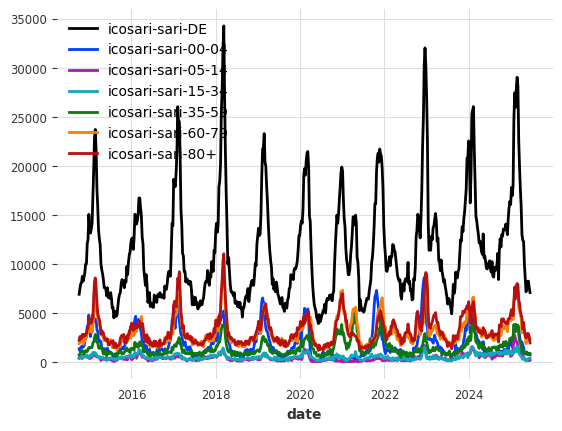

In [10]:
targets.plot()

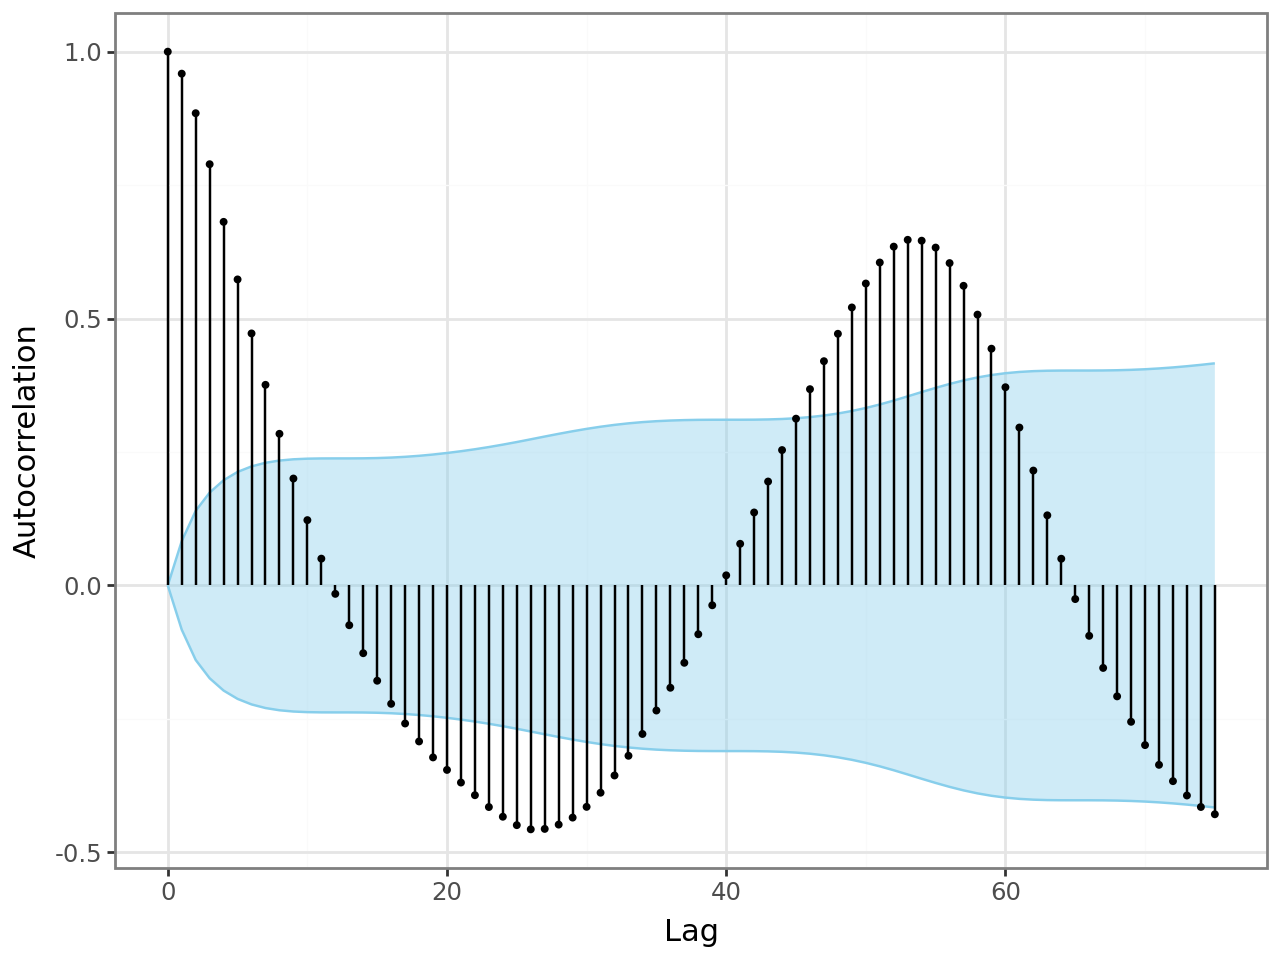

In [25]:
p = plot_acf(targets['icosari-sari-DE'].pd_series(), nlags=75, bartlett=True)
p

In [26]:
p.save("../figures/acf_bartlett.pdf", width = 160, height = 80, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 160.0 x 80.0 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/acf_bartlett.pdf


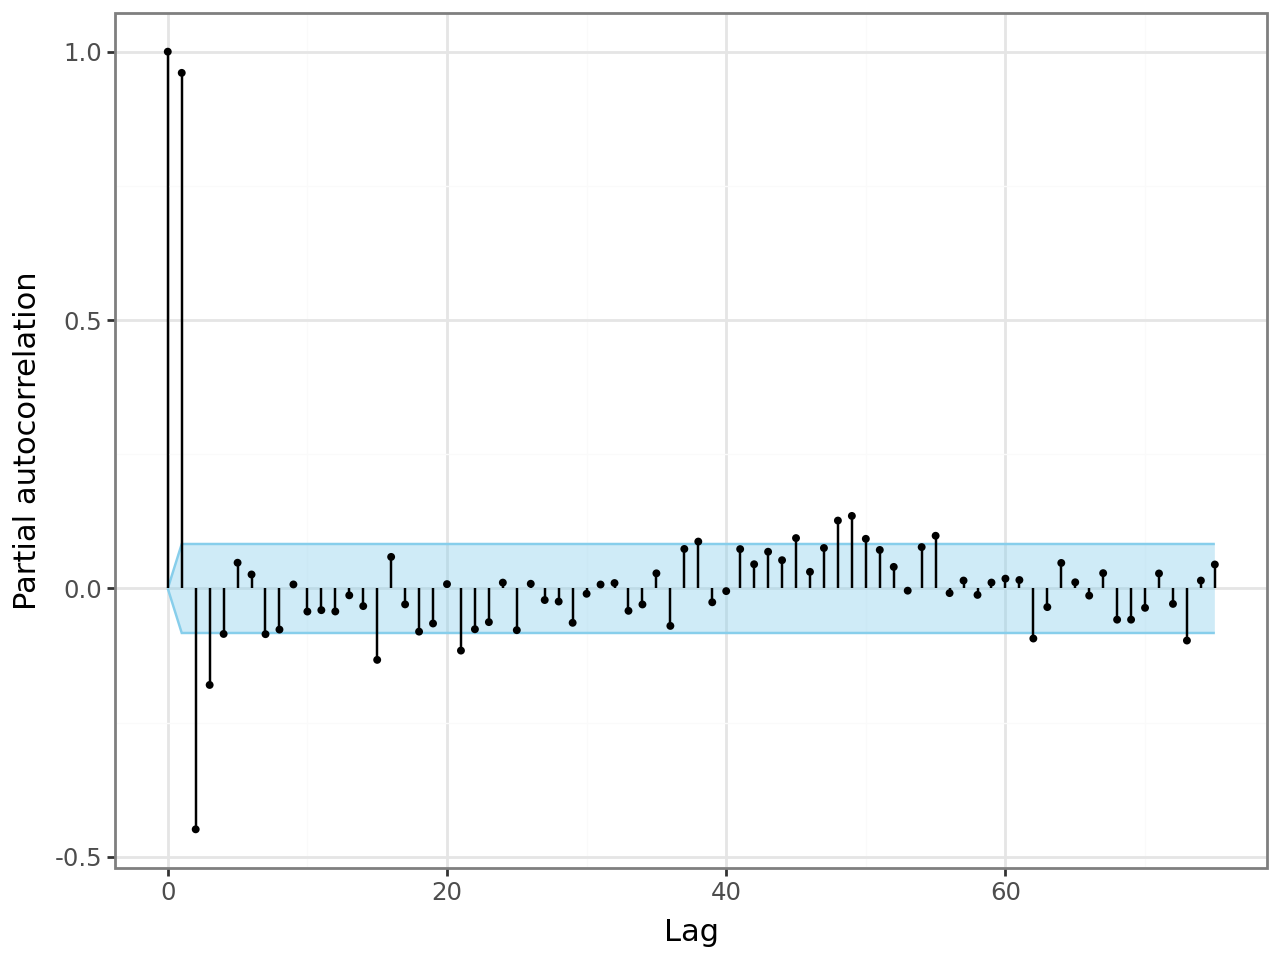

In [27]:
p = plot_pacf(targets['icosari-sari-DE'].pd_series(), nlags=75)
p

In [28]:
p.save("../figures/pacf.pdf", width = 160, height = 80, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 160.0 x 80.0 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/pacf.pdf


# Remove seasonality

In [13]:
ts = targets['icosari-sari-DE']

In [14]:
df = ts.pd_dataframe()
df['week'] = df.index.isocalendar().week

adjusted = []

for idx, (t, row) in enumerate(df.iterrows()):
    current_week = row['week']
    
    # Filter only past values with same week number
    past_values = df.iloc[:idx]
    past_same_week = past_values[past_values['week'] == current_week]

    if not past_same_week.empty:
        seasonal_mean = past_same_week[ts.columns[0]].mean()
        adjusted_value = row[ts.columns[0]] - seasonal_mean
    else:
        adjusted_value = None  

    adjusted.append(adjusted_value)

df['deseasonalized'] = adjusted
ts_deseasonalized = TimeSeries.from_dataframe(df, value_cols='deseasonalized')

<Axes: xlabel='date'>

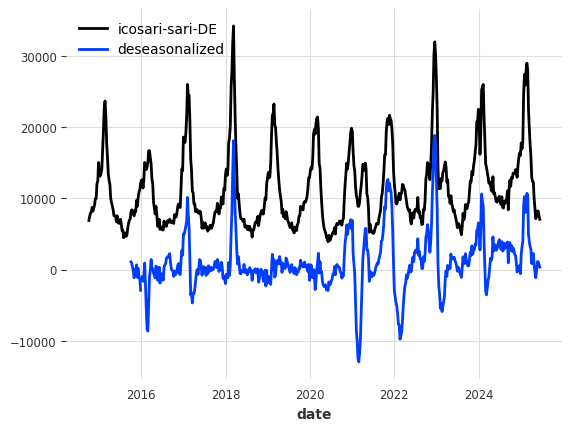

In [15]:
ts.plot()
ts_deseasonalized.plot()

In [16]:
missing_pct = missing_values_ratio(ts_deseasonalized[52:])
print(f"{missing_pct:.2%} of points are NaN")

0.20% of points are NaN


In [17]:
ts_deseasonalized = fill_missing_values(ts_deseasonalized[52:], fill="auto")

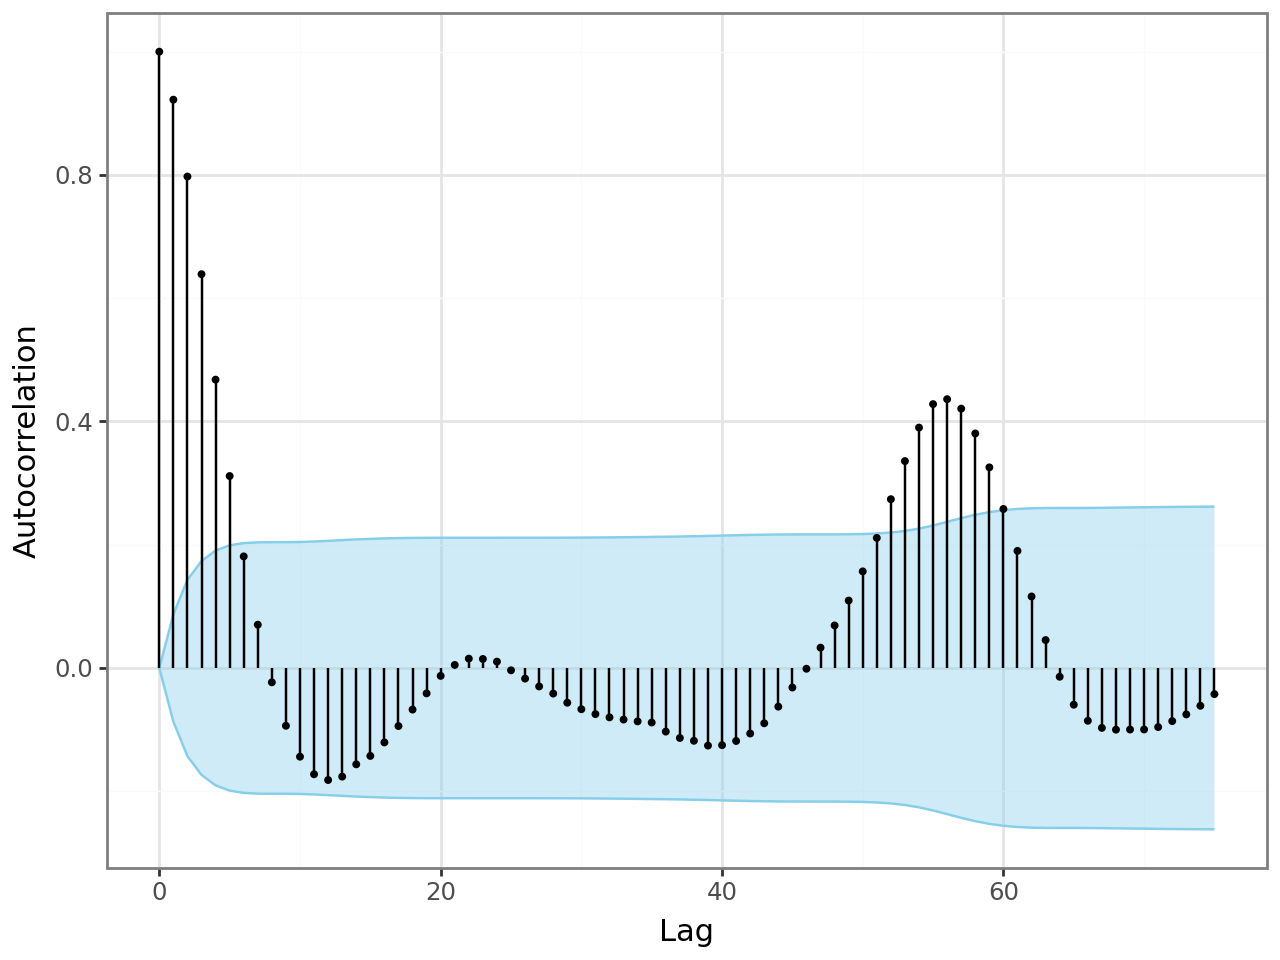

In [18]:
plot_acf(ts_deseasonalized.pd_series())

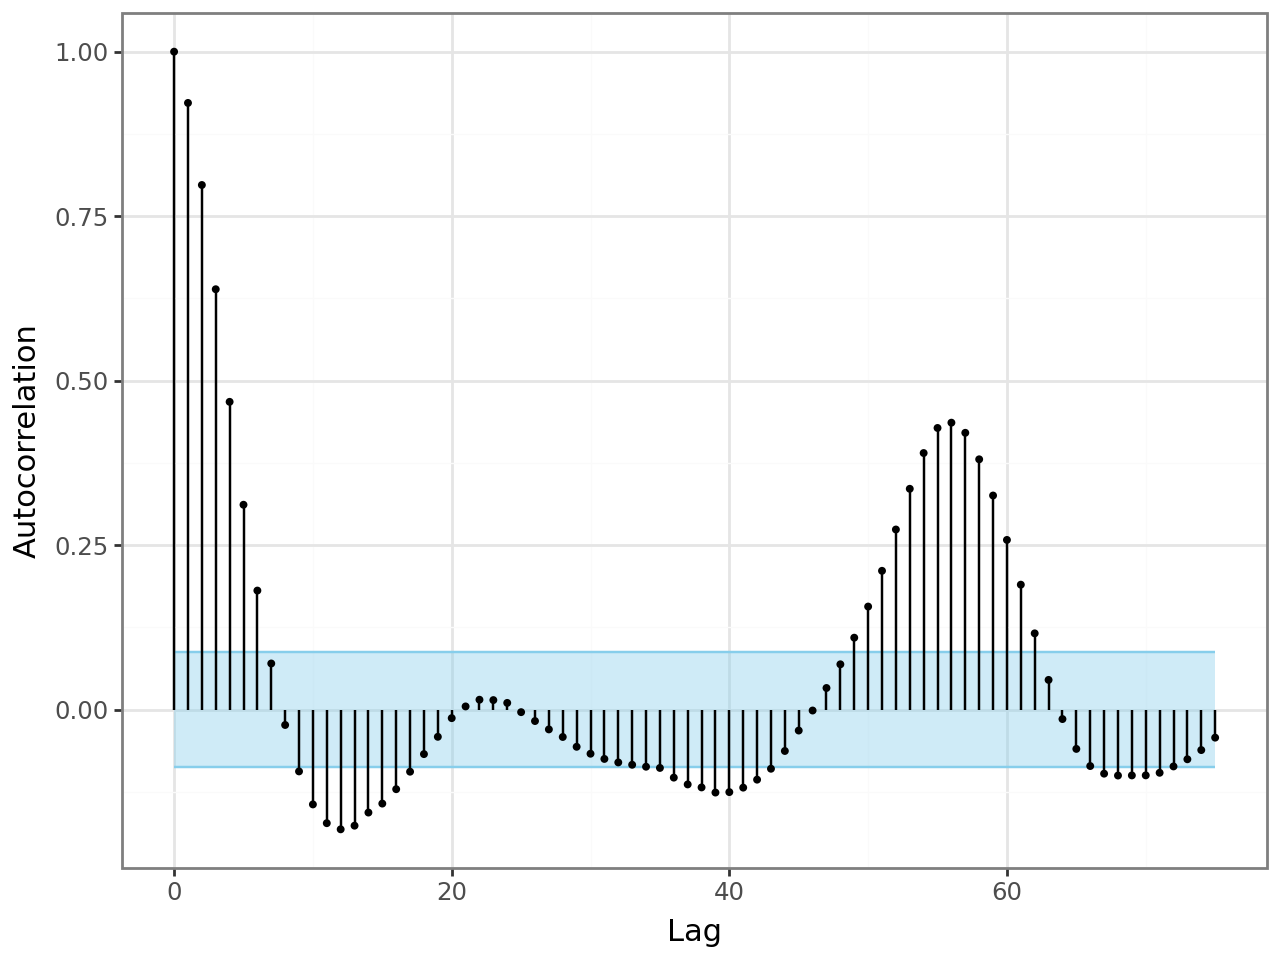

In [29]:
plot_acf(ts_deseasonalized.pd_series(), bartlett=False)

# STL

In [27]:
from statsmodels.tsa.seasonal import STL

In [28]:
ts = targets['icosari-sari-DE']

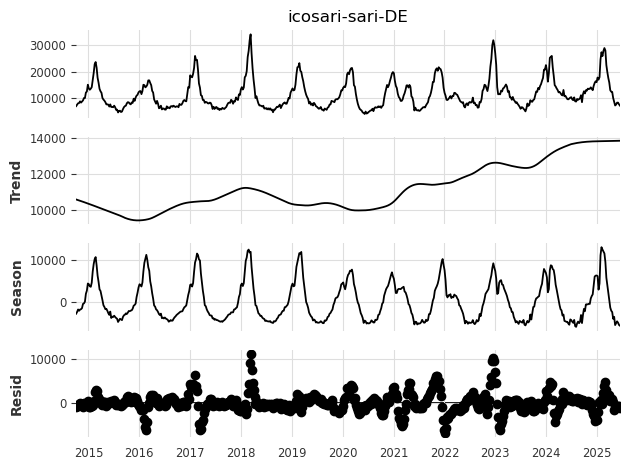

In [30]:
stl = STL(ts.pd_series())
res = stl.fit()
fig = res.plot()

<Axes: xlabel='date'>

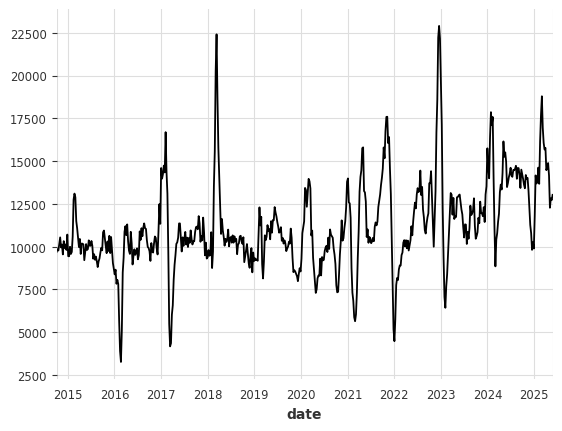

In [100]:
(res.observed - res.seasonal).plot()

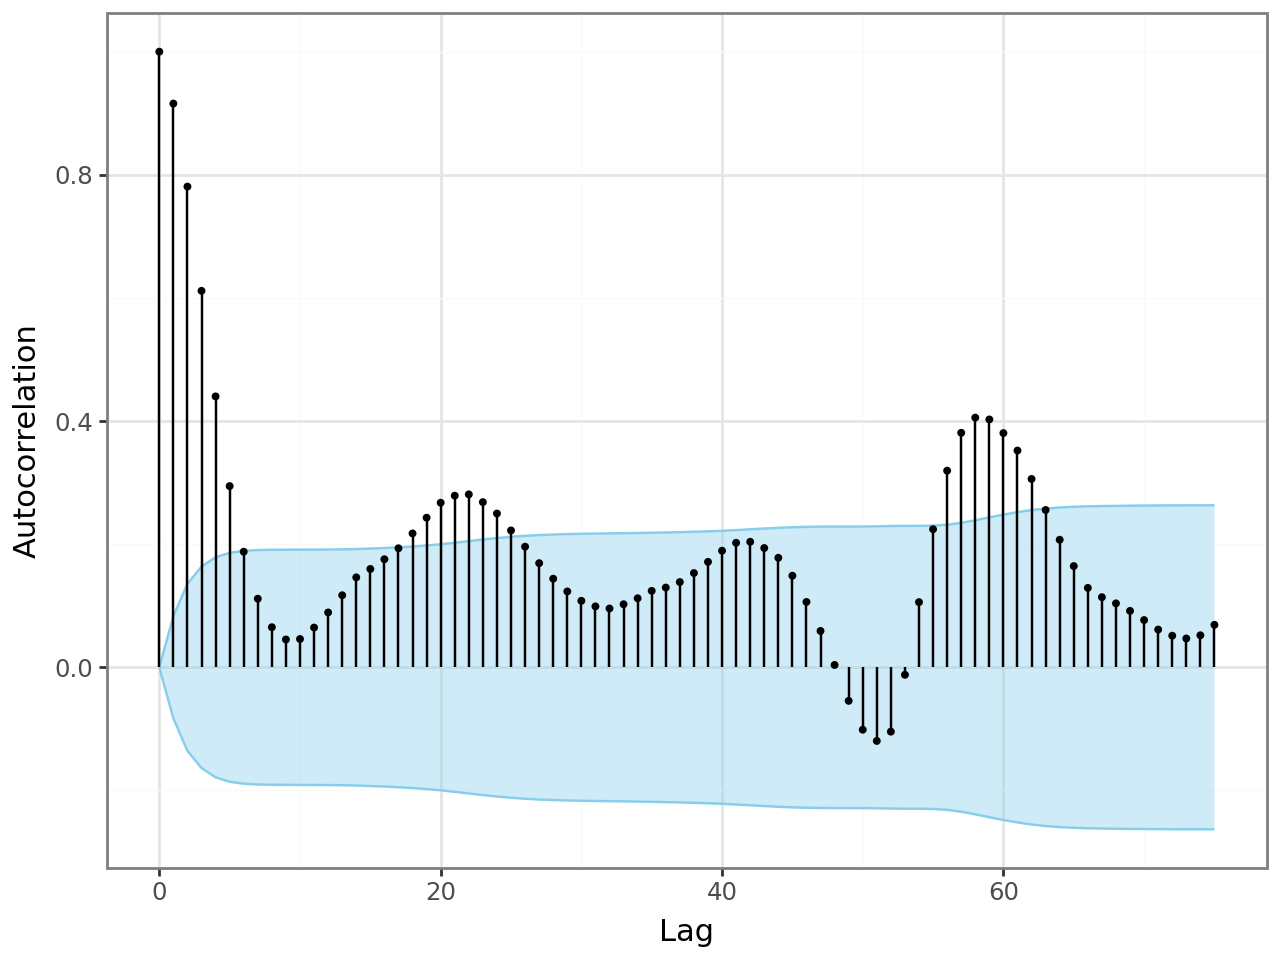

In [34]:
plot_acf((res.observed - res.seasonal))

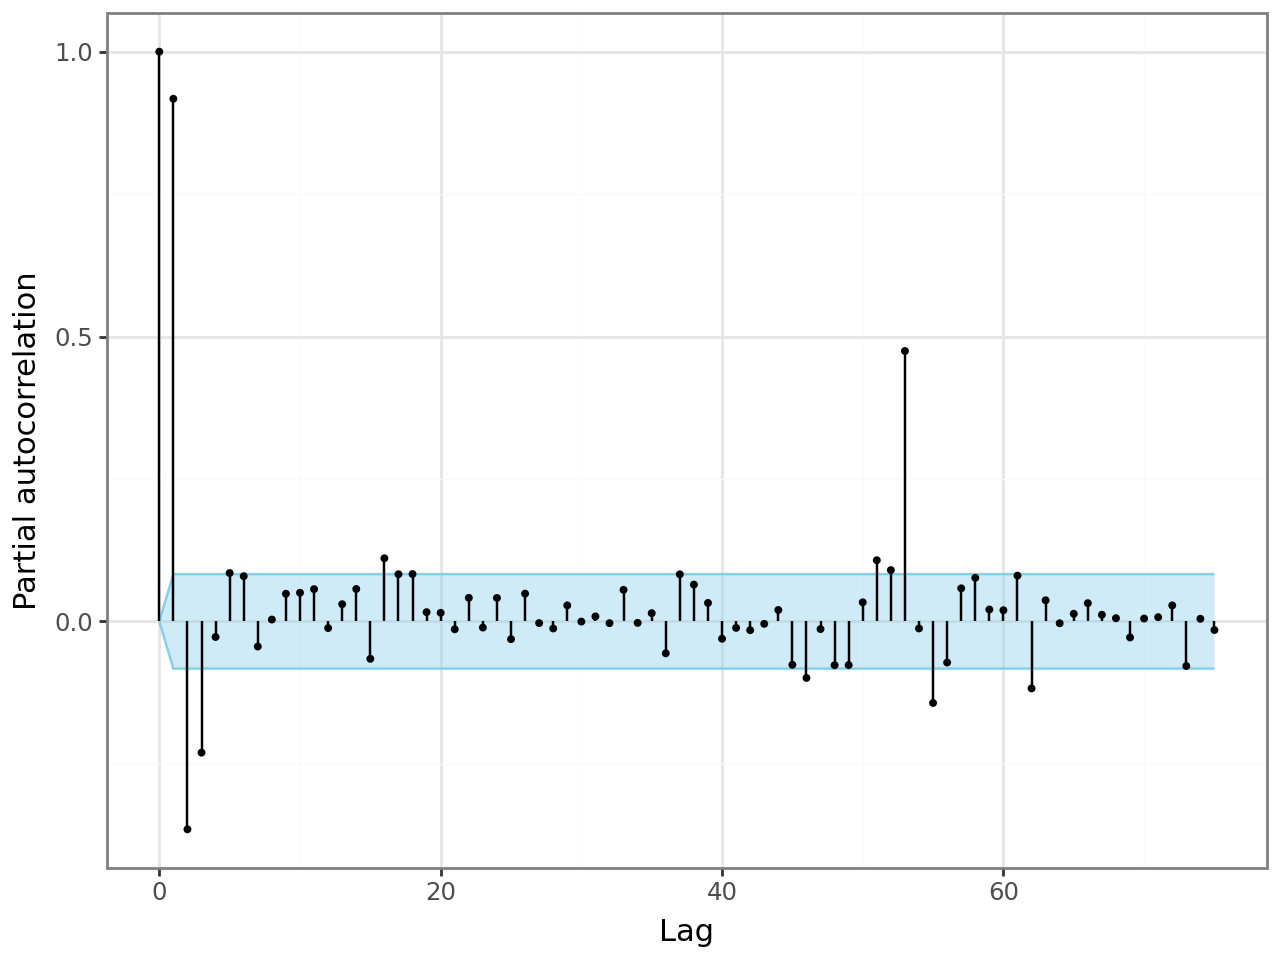

In [35]:
plot_pacf((res.observed - res.seasonal))

In [31]:
#fig.savefig("../figures/stl.pdf", width = 160, height = 70, units="mm", dpi=600)